## ECOSTRESS Land Surface Temperature over Clear Lake Reservoir before and after the 2019 Tucker Fire

**Waterhackweek 2020: Fire and Water**



In [35]:
%matplotlib inline
from shapely.geometry import box, mapping
import os
from affine import Affine
import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import contextily as cx
import ulmo
from shapely.geometry import box
from matplotlib import pyplot
import folium
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import geopandas as gpd
import rasterio
import warnings
import matplotlib.pyplot as plt
import rasterio.mask
import fiona
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [36]:
# Read in Clear Lake Reservoir
Clear = gpd.read_file('zip://ECOSTRESS/Clear_Lake_Res.zip/Clear_Lake_Res.shp', crs='epsg:4326')



# Read in 2019 Tucker Fire
Fire = gpd.read_file('zip://ECOSTRESS/ca_tucker_20190804_0000_dd83.zip/ca_tucker_20190804_0000_dd83.shp', crs='epsg:4326')


In [37]:
# Display metadata collected from California Department of Fish and Wildlife
Clear

,DFGWATERID,TYPE,NAME,GNIS_NAME,GNIS_ID,COUNTY,QUAD_NAME,QUAD_CODE,LAT_NAD83,LON_NAD83,UTM_ZONE,UTM_N_N83,UTM_E_N83,MTR,elev_ft,sfc_acres,Shape_Leng,Shape_Area,geometry
0,8177,perennial,Clear Lake Reservoir,Clear Lake Reservoir,221199.0,Modoc,DOUBLE HEAD MTN.,41121G2,41.865752,-121.144879,10.0,4.636535e+06,653962.164441,M47N 07E,4484,25012.128035,110372.801128,1.012209e+08,"MULTIPOLYGON Z (((-89566.185 434787.792 0.000,..."


In [38]:
# Display metadata collected for 2019 Tucker Fire
Fire

,IRWINID,mapmethod,unitIDProt,unitIDOwn,incidentID,fireName,perDatTime,comments,agency,active,...,inciwebId,firecode,mergeid,compfirecd,fireNum,ComplexNm,state,inComplex,gisAcres,geometry
0,{1DAFC388-98C2-401A-849E-C435E3260425},Mixed Methods,CAMDF,CAMDF,2019-CAMDF-000509,TUCKER,8/4/2019,Event Standard Perims,USFS,N,...,6470,MH73,None,None,000509,None,CA,N,14154.060004,"POLYGON ((-121.30266 41.76161, -121.30267 41.7..."


In [39]:
# Interactive map

# Note: There are other basemap tiles besides StamenTerrain
m = folium.Map(tiles='StamenTerrain', attr='ESRI')
# Bounding box

folium.GeoJson(
    Clear.geometry,
    style_function=lambda feature: {'color': 'blue', 'fillOpacity':0.1}
).add_to(m)

folium.GeoJson(
    Fire.geometry,
    style_function=lambda feature: {'color': 'red', 'fillOpacity':0.1}
).add_to(m)

# Set the map extent (bounds) to the extent of the bounding box
m.fit_bounds(m.get_bounds())

In [40]:
m

In [41]:
eco_tiff_path = 'ECOSTRESS'
ext = '.tif'
product = 'SDS_LST_doy'
# get list of all tif files
file_list = []
for root, dirs, files in os.walk(eco_tiff_path):
    for file in files:
        if file.endswith(ext):
            if product in file:
                 file_list.append( os.path.join(root, file) )
                    
                    
eco_lst = xr.open_rasterio(file_list[131]) ##### REFER TO EXCEL INDEX FILE HERE #######


clearlake = gpd.read_file('zip://ECOSTRESS/Clear_Lake_Res.zip')
clearlake.head()

## Apply 1,000 meter buffer to account for variable lake depth/boundary
clearlake_buffer = clearlake.buffer(-1000)

In [42]:
clearlake = clearlake.to_crs(eco_lst.crs)
clearlake_buffer = clearlake_buffer.to_crs(eco_lst.crs)

/opt/conda/envs/whw/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [43]:
scaled_eco_lst = eco_lst * float(eco_lst.attrs['scale_factor'])
print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
print('Shapefile CRS: {}'.format(clearlake.crs))

ECOSTRESS CRS: +init=epsg:4326
Shapefile CRS: +init=epsg:4326 +type=crs


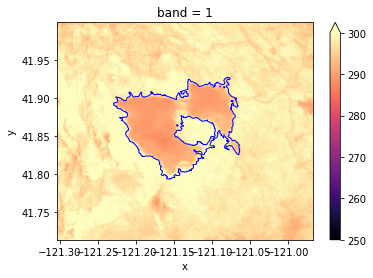

In [44]:
fig, ax = plt.subplots()

scaled_eco_lst.plot(x='x', y='y', ax=ax, vmin=250, vmax=300, cmap='magma')

clearlake.plot(ax=ax, edgecolor='blue', facecolor='none');

ax.set_aspect(1)

In [45]:


clearlake_lst = eco_lst.rio.clip(clearlake_buffer.geometry.apply(mapping))

# switch our zero values to nan values
clearlake_lst = clearlake_lst.where(clearlake_lst > 0)

/opt/conda/envs/whw/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [46]:
# scale our clipped dataset and convert from K to C
scaled_clearlake_lst = ( clearlake_lst * float(eco_lst.attrs['scale_factor']) ) - 273.15

In [47]:
# Compute zonal statistics
# Remove NaN pixel values
values = scaled_clearlake_lst.values.flatten()
values = values[~np.isnan(values)]

clearlake_lst_mean = values.mean()
clearlake_lst_max = values.max()
clearlake_lst_min = values.min()
clearlake_lst_std = values.std()

# Print zonal statistics
summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(clearlake_lst_mean,1),
                                                             np.round(clearlake_lst_max,1),
                                                             np.round(clearlake_lst_min,1),
                                                             np.round(clearlake_lst_std,1))

print(summary_stats)

Mean: 16.9
Max: 25.2
Min: 14.3
Std: 1.1


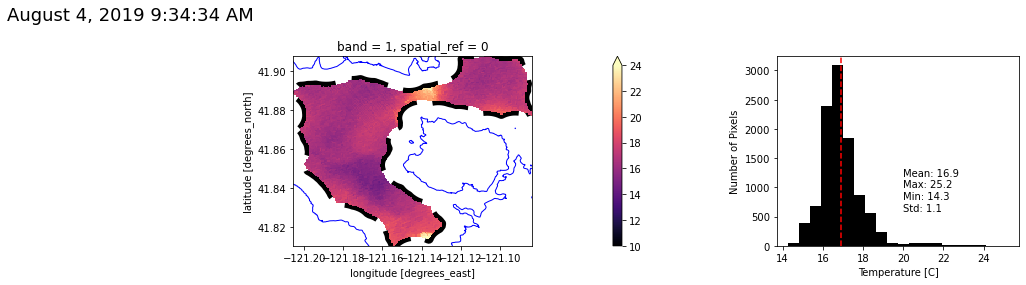

In [48]:
#######CHANGE TITLE TO MATCH INDEX############################


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,4), gridspec_kw={'width_ratios': [2,.3]})
fig.suptitle('August 4, 2019 9:34:34 AM', fontsize=18)
# image
clearlake.plot(ax=ax1, edgecolor='blue', facecolor='none');
clearlake_buffer.plot(ax=ax1, edgecolor='black',ls='--',lw=10, facecolor='none');
scaled_clearlake_lst.plot(x='x', y='y', ax=ax1, vmin=10, vmax=24, cmap='magma')
ax1.set_aspect(1)


# histogram
ax2.hist(values, bins=20, facecolor='k');
ax2.axvline(x=clearlake_lst_mean, c='r', linestyle='--')
ax2.text(20,600,summary_stats)
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel('Temperature [C]')

plt.tight_layout()